In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix 

import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D

import warnings
warnings.filterwarnings('ignore')



print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.11.0


In [2]:
IMAGE_SIZE = [176, 176]

## **Loading Training, Validation and Testing Data** > *Pre-processed on Local Machine*

In [3]:
data = np.load("/kaggle/input/data-weights/Variables.npz")

In [4]:
train_data, test_data, train_labels, test_labels, val_data, val_labels = [data[key] for key in data.files]

In [110]:
print(f'Training Size : {train_data.shape} | Training Labels : {train_labels.shape}')
print(f'Validation Size : {val_data.shape} | Validation Labels : {val_labels.shape}')
print(f'Testing Size : {test_data.shape}   |  Testing Labels : {test_labels.shape}')

Training Size : (7787, 176, 176, 3) | Training Labels : (7787, 4)
Validation Size : (2197, 176, 176, 3) | Validation Labels : (2197, 4)
Testing Size : (2816, 176, 176, 3)   |  Testing Labels : (2816, 4)


In [111]:
import gc
gc.collect()

30552

# **BUILDING MODEL** 

#### - This Block = Structure of Latest Model
#### - Model 1 and 2 Done

In [112]:
def conv_block(filters, act='relu'):
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())
    
    return block

In [113]:
def dense_block(units, dropout_rate, act='relu'):
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

In [114]:
def construct_model(act='relu'):
    
    model = Sequential([
        Input(shape=(*IMAGE_SIZE, 3)),
        
        Conv2D(16, 3, activation=act, padding='same'),
        Conv2D(16, 3, activation=act, padding='same'),
        MaxPool2D(),
        
        conv_block(32),
        
        conv_block(64),
        
        conv_block(128),
        Dropout(0.2),
        
        conv_block(256),
        Dropout(0.2),
        
        Flatten(),
        
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        Dense(4, activation='softmax') 
        
    ], 
        name = "cnn_model")

    return model

In [115]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

In [116]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)

In [117]:
model = construct_model()

CALLBACKS = [my_callback, rop_callback]

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'), 
           tfa.metrics.F1Score(num_classes=4)]
    
model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS
             )

model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 176, 176, 16)      448       
                                                                 
 conv2d_51 (Conv2D)          (None, 176, 176, 16)      2320      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 88, 88, 16)       0         
 g2D)                                                            
                                                                 
 sequential_35 (Sequential)  (None, 44, 44, 32)        14016     
                                                                 
 sequential_36 (Sequential)  (None, 22, 22, 64)        55680     
                                                                 
 sequential_37 (Sequential)  (None, 11, 11, 128)       221952    
                                                         

In [119]:
gc.collect()

23

# **Represents History of Latest Model**

#### - Model 1 and 2 Done 

In [120]:
EPOCHS = 100

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/100


2023-03-30 18:00:54.626807: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape incnn_model/dropout_29/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


244/244 [==============================] - 22s 58ms/step - loss: 1.7245 - acc: 0.2731 - auc: 0.5314 - f1_score: 0.2713 - val_loss: 3.4858 - val_acc: 0.2467 - val_auc: 0.5121 - val_f1_score: 0.0989 - lr: 0.0010
Epoch 2/100
244/244 [==============================] - 12s 49ms/step - loss: 1.3136 - acc: 0.3874 - auc: 0.6701 - f1_score: 0.3711 - val_loss: 9.2600 - val_acc: 0.2467 - val_auc: 0.4978 - val_f1_score: 0.0989 - lr: 0.0010
Epoch 3/100
244/244 [==============================] - 12s 50ms/step - loss: 1.0102 - acc: 0.5381 - auc: 0.8132 - f1_score: 0.5243 - val_loss: 10.2919 - val_acc: 0.2467 - val_auc: 0.4982 - val_f1_score: 0.0989 - lr: 0.0010
Epoch 4/100
244/244 [==============================] - 12s 48ms/step - loss: 0.8367 - acc: 0.6079 - auc: 0.8681 - f1_score: 0.5929 - val_loss: 2.5437 - val_acc: 0.4096 - val_auc: 0.6723 - val_f1_score: 0.3235 - lr: 0.0010
Epoch 5/100
244/244 [==============================] - 12s 49ms/step - loss: 0.7743 - acc: 0.6393 - auc: 0.8880 - f1_score:

# **Model Model_2**

#### - Custom + Reduce LR on Plateau Callbacks
#### - No Dropout After conv block(64)

In [127]:
model_dir = "./Model " + "Model_2"
model.save(model_dir, save_format='h5')

In [128]:
model2 = tf.keras.models.load_model("/kaggle/working/Model Model_2")
model2.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 176, 176, 16)      448       
                                                                 
 conv2d_51 (Conv2D)          (None, 176, 176, 16)      2320      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 88, 88, 16)       0         
 g2D)                                                            
                                                                 
 sequential_35 (Sequential)  (None, 44, 44, 32)        14016     
                                                                 
 sequential_36 (Sequential)  (None, 22, 22, 64)        55680     
                                                                 
 sequential_37 (Sequential)  (None, 11, 11, 128)       221952    
                                                         

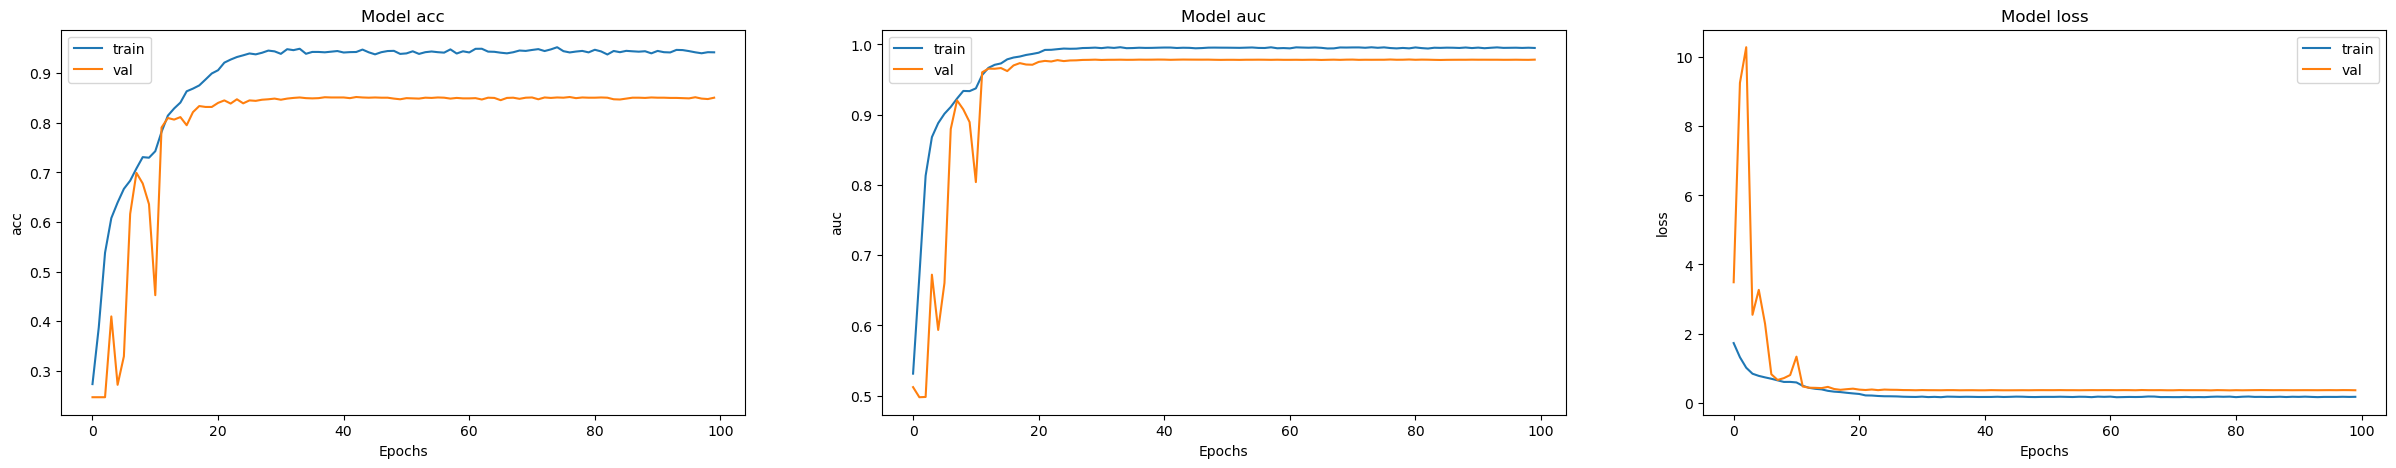

In [124]:
fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [131]:
train_scores = model2.evaluate(train_data, train_labels)
val_scores = model2.evaluate(val_data, val_labels)
test_scores = model2.evaluate(test_data, test_labels)

88/88 [==============================] - 1s 15ms/step - loss: 0.3364 - acc: 0.8626 - auc: 0.9805 - f1_score: 0.8618


In [134]:
print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

Training Accuracy: 98.39%
Validation Accuracy: 85.07%
Testing Accuracy: 86.26%


In [135]:
CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

pred_labels = model2.predict(test_data)

def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

88/88 [==============================] - 1s 13ms/step
                  precision    recall  f1-score   support

     NonDemented       0.91      0.96      0.94       714
VeryMildDemented       1.00      1.00      1.00       692
    MildDemented       0.86      0.68      0.76       686
ModerateDemented       0.71      0.81      0.75       724

       micro avg       0.86      0.86      0.86      2816
       macro avg       0.87      0.86      0.86      2816
    weighted avg       0.87      0.86      0.86      2816
     samples avg       0.86      0.86      0.86      2816



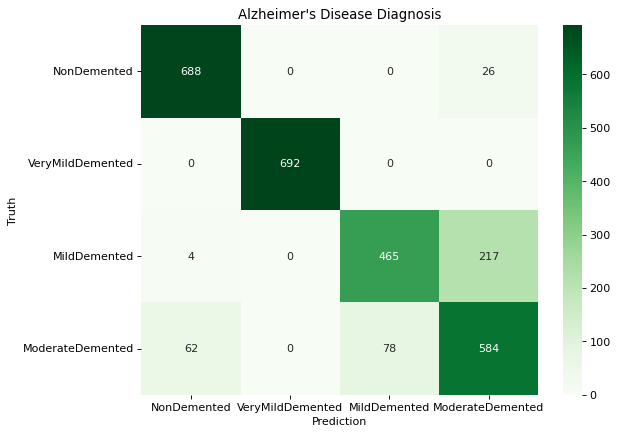

In [137]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [138]:
print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 86.2 %
Matthew's Correlation Coefficient: 81.88 %


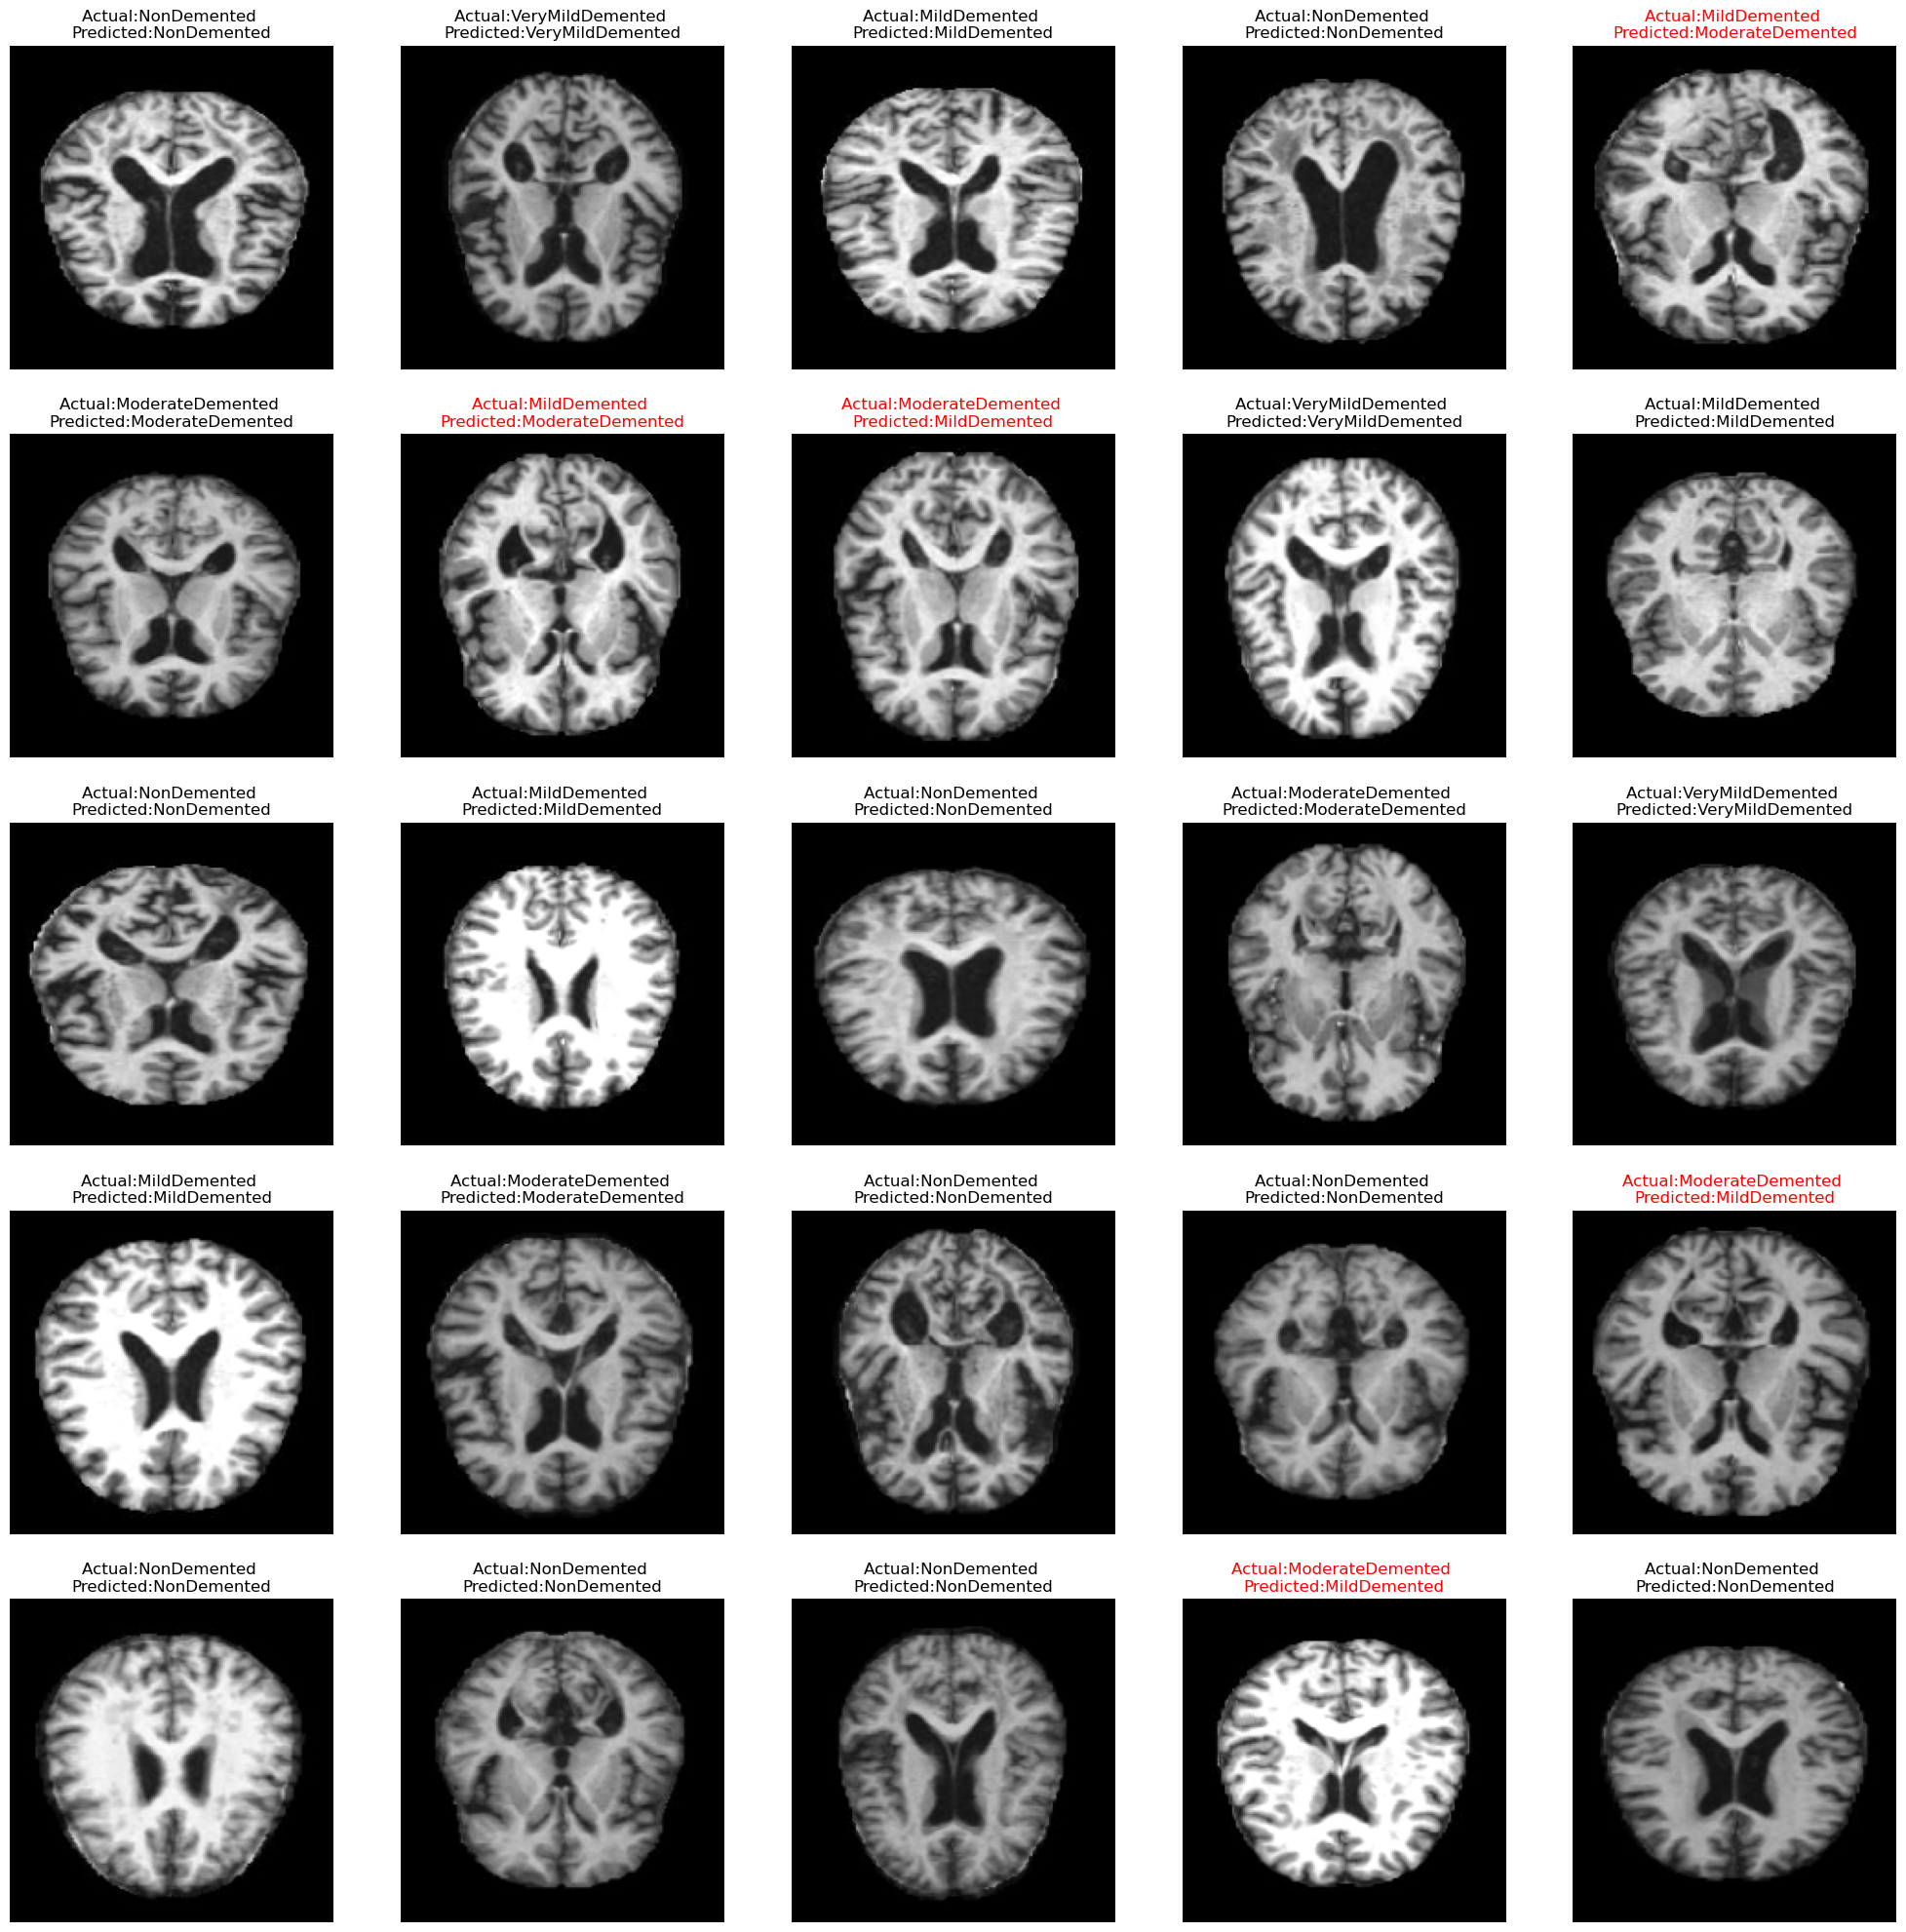

In [141]:
labels = dict(zip([0,1,2,3], CLASSES))
plt.figure(figsize=(25, 25))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(test_data[i])
    plt.axis("off")
    
    if np.argmax(test_labels[i]) != np.argmax(pred_labels[i]):
        plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(test_labels[i])],labels[np.argmax(pred_labels[i])]), 
                  color='red')
    else:
        plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(test_labels[i])],labels[np.argmax(pred_labels[i])]))

---------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------

# **Model Model_1**

#### - Only Custom Callback 
#### - Dropout after conv_block(64)

In [38]:
model_dir = "./Model " + "Model_1"
model.save(model_dir, save_format='h5')

In [67]:
model1 = tf.keras.models.load_model("/kaggle/working/Model Model_1")

In [108]:
model1.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 176, 176, 16)      448       
                                                                 
 conv2d_31 (Conv2D)          (None, 176, 176, 16)      2320      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 88, 88, 16)       0         
 g2D)                                                            
                                                                 
 sequential_21 (Sequential)  (None, 44, 44, 32)        14016     
                                                                 
 sequential_22 (Sequential)  (None, 22, 22, 64)        55680     
                                                                 
 dropout_18 (Dropout)        (None, 22, 22, 64)        0         
                                                         

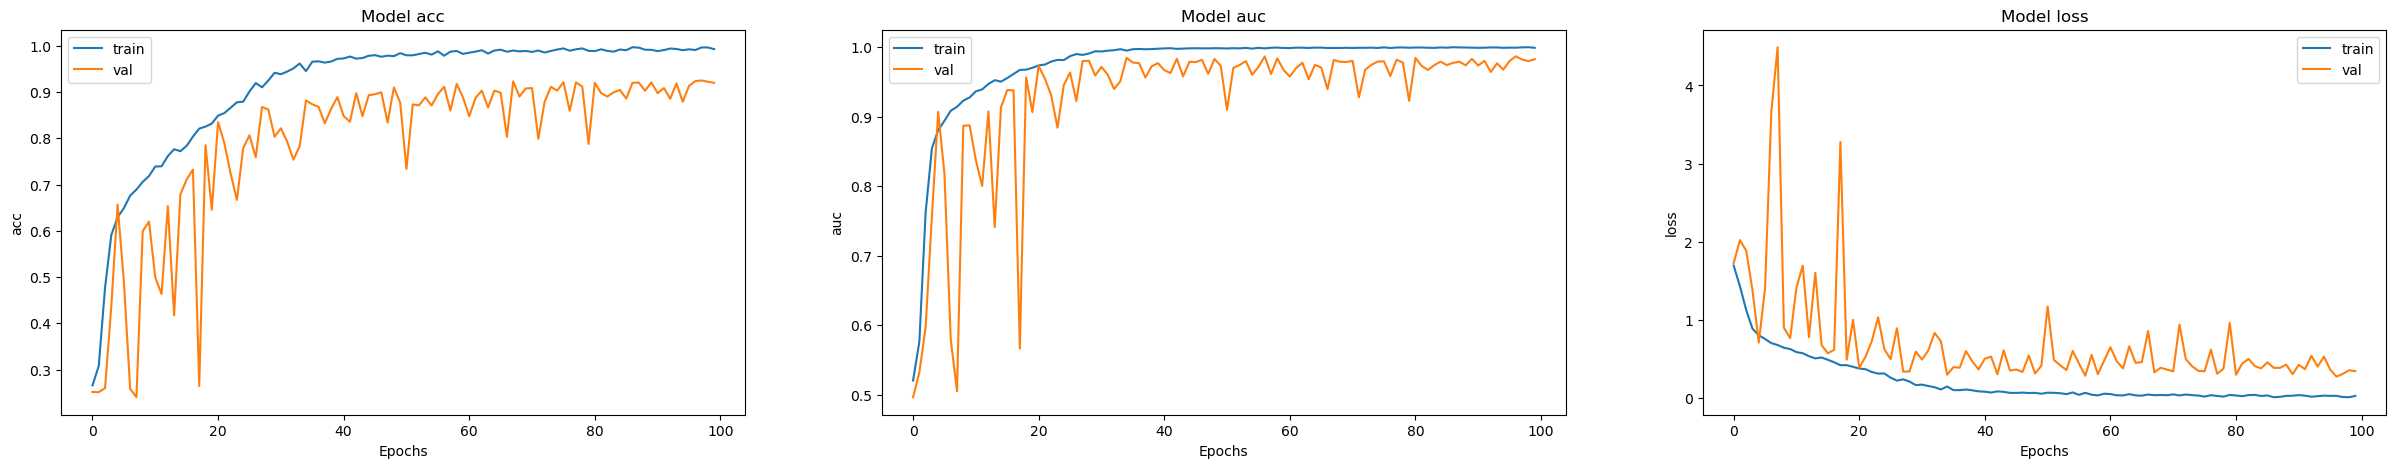

In [41]:
fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [70]:
train_scores = model1.evaluate(train_data, train_labels)
val_scores = model1.evaluate(val_data, val_labels)
test_scores = model1.evaluate(test_data, test_labels)

88/88 [==============================] - 2s 22ms/step - loss: 0.3158 - acc: 0.9251 - auc: 0.9835 - f1_score: 0.9250


In [73]:
print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

Training Accuracy: 99.87%
Validation Accuracy: 91.99%
Testing Accuracy: 92.51%


In [74]:
CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

pred_labels = model1.predict(test_data)

def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

88/88 [==============================] - 1s 12ms/step
                  precision    recall  f1-score   support

     NonDemented       0.95      0.98      0.97       714
VeryMildDemented       1.00      1.00      1.00       692
    MildDemented       0.89      0.85      0.87       686
ModerateDemented       0.86      0.88      0.87       724

       micro avg       0.93      0.93      0.93      2816
       macro avg       0.93      0.93      0.93      2816
    weighted avg       0.92      0.93      0.92      2816
     samples avg       0.93      0.93      0.93      2816



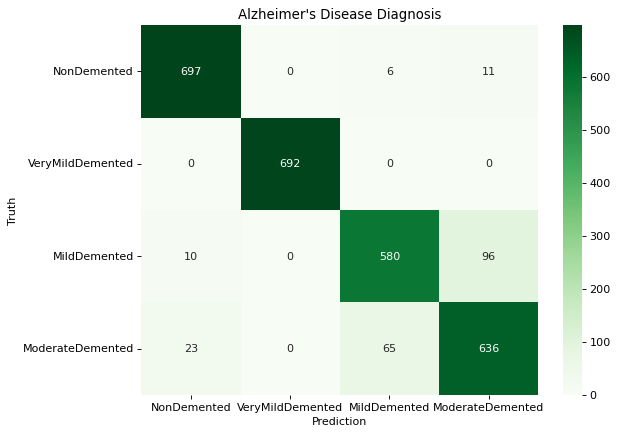

In [75]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [76]:
print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 92.5 %
Matthew's Correlation Coefficient: 90.02 %


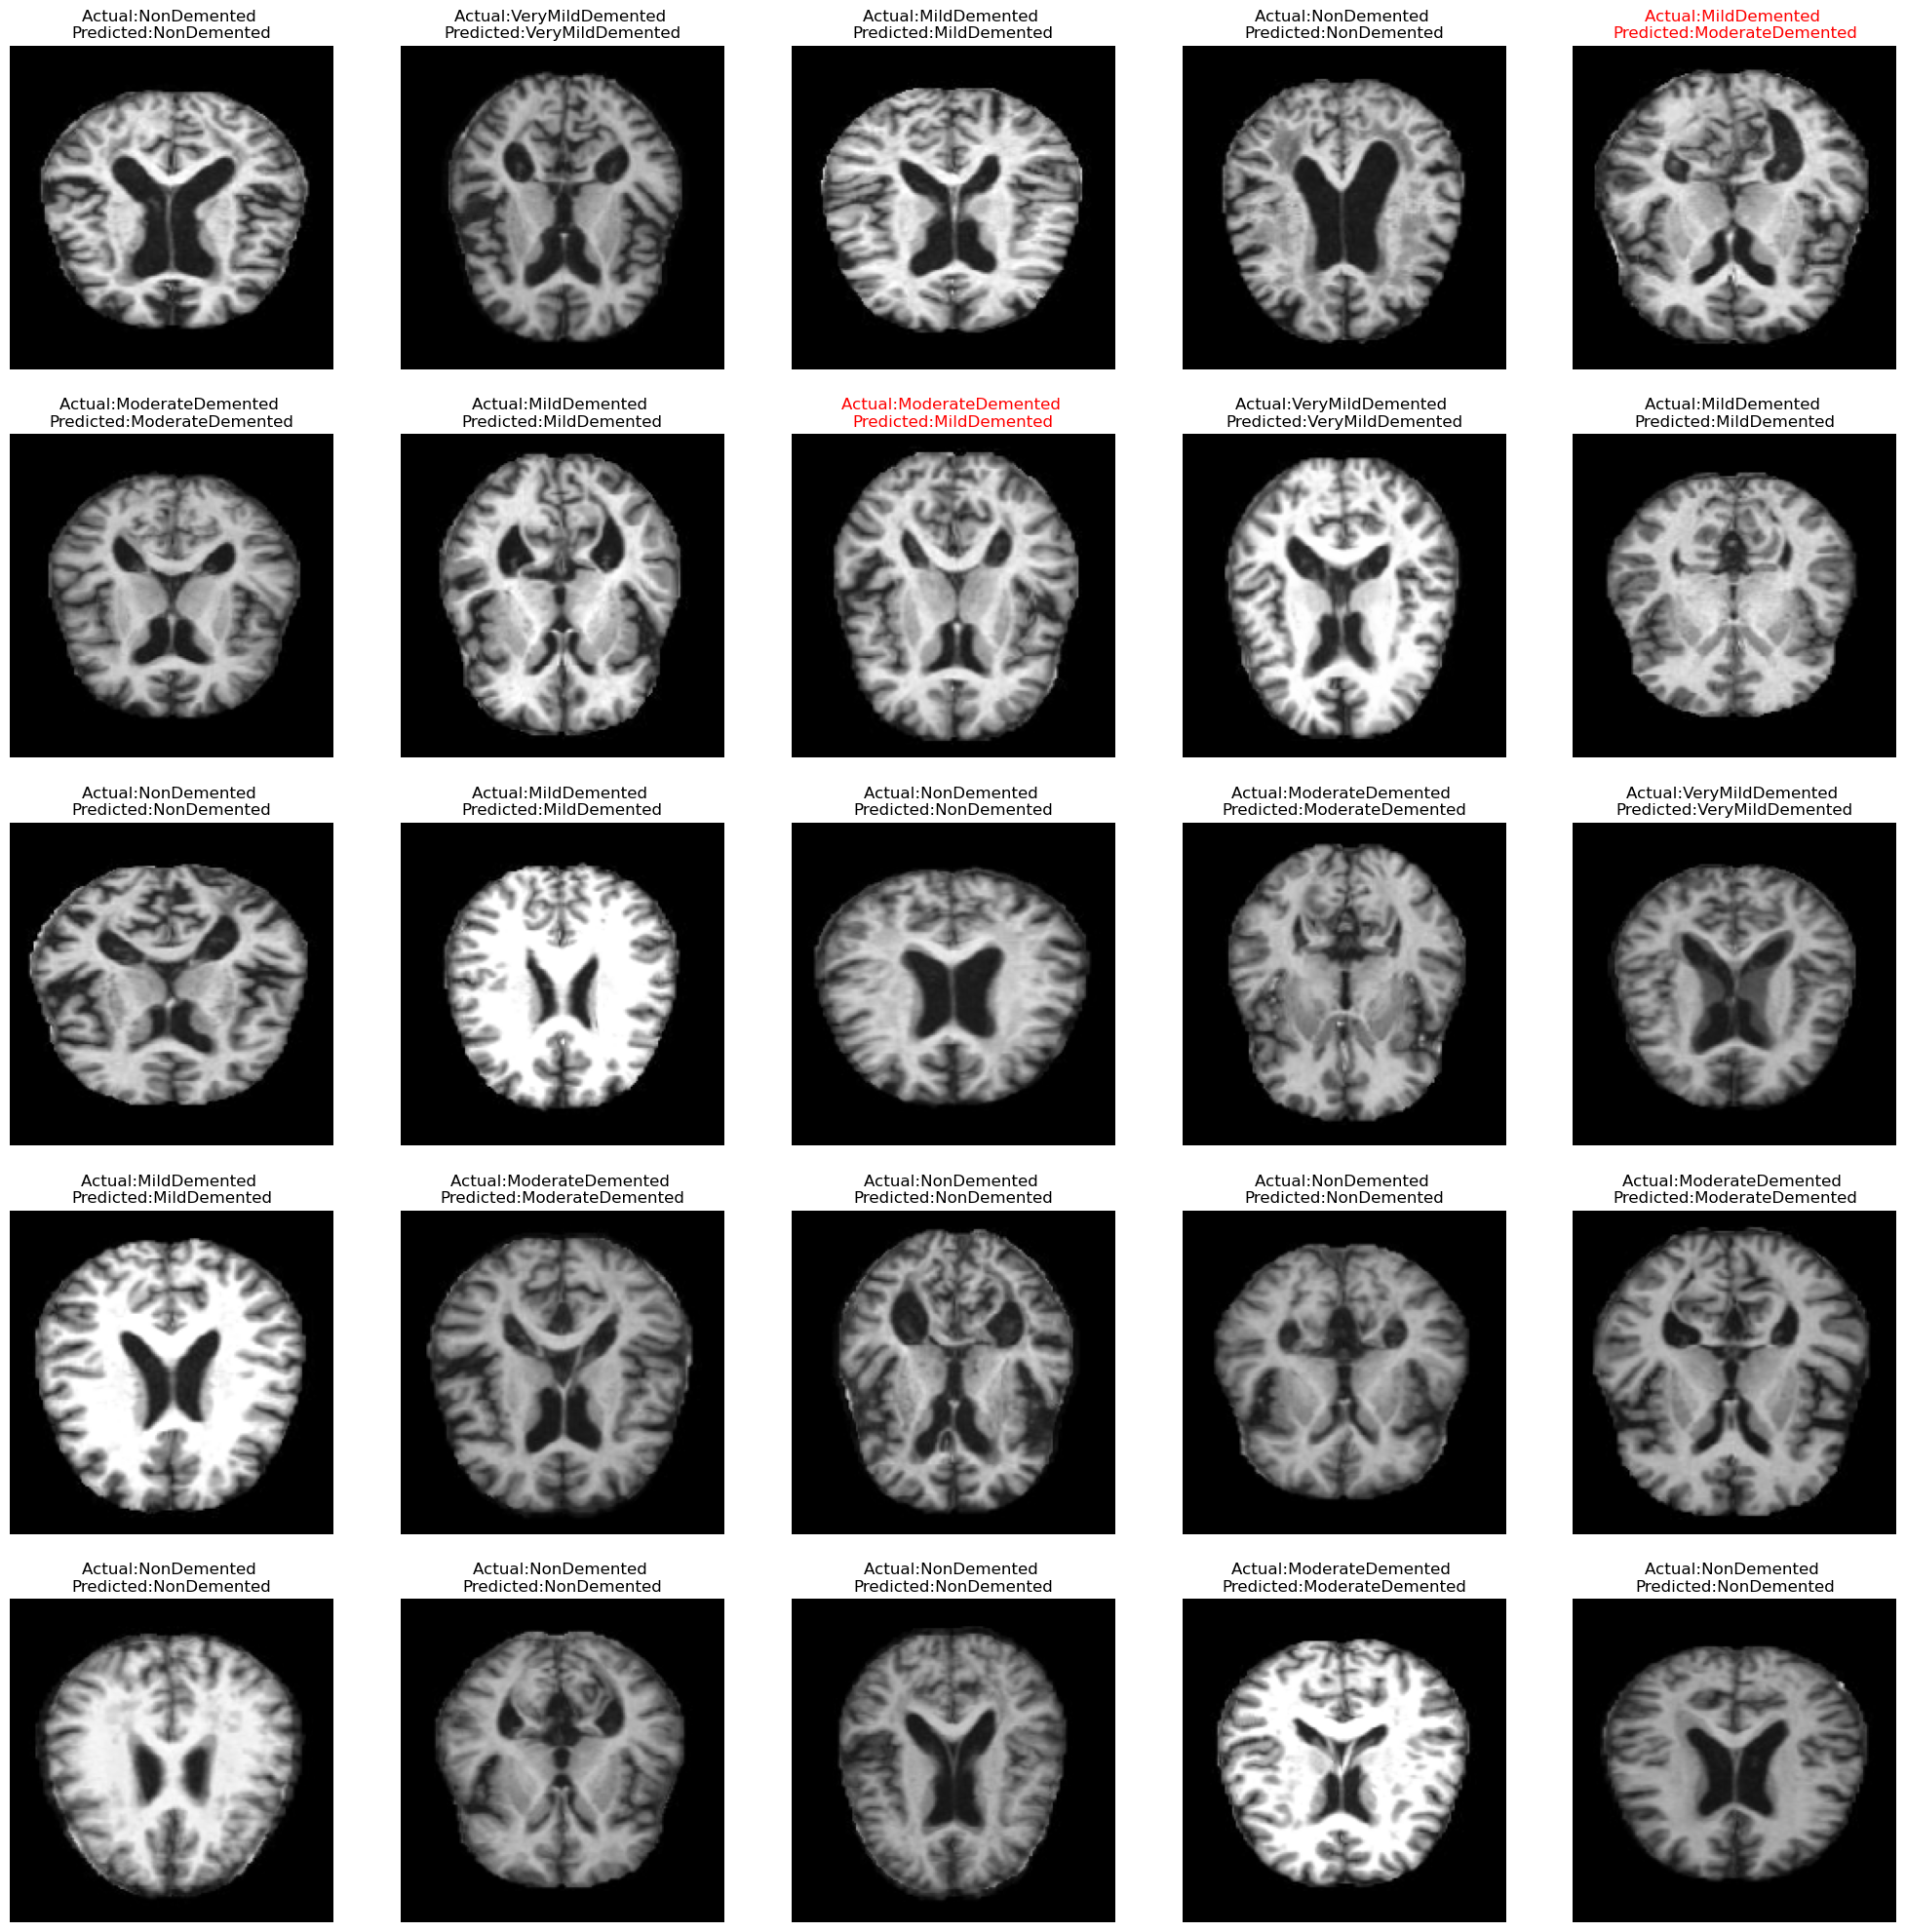

In [109]:
labels = dict(zip([0,1,2,3], CLASSES))
plt.figure(figsize=(25, 25))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(test_data[i])
    plt.axis("off")
    
    if np.argmax(test_labels[i]) != np.argmax(pred_labels[i]):
        plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(test_labels[i])],labels[np.argmax(pred_labels[i])]), 
                  color='red')
    else:
        plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(test_labels[i])],labels[np.argmax(pred_labels[i])]))